<a href="https://colab.research.google.com/github/CatarinaL/ddosLogs/blob/master/class_balance_and_redimensioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
!pip install category_encoders
!pip install -U imbalanced-learn
!pip install pycaret[full]

import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import category_encoders as ce
from category_encoders.wrapper import PolynomialWrapper

     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 174kB 5.7MB/s 
     |████████████████████████████████| 6.8MB 27.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3
     |████████████████████████████████| 256kB 4.2MB/s 
     |████████████████████████████████| 1.8MB 35.0MB/s 
     |████████████████████████████████| 13.9MB 284kB/s 
     |████████████████████████████████| 66.3MB 53kB/s 
     |████████████████████████████████| 1.6MB 45.9MB/s 
     |████████████████████████████████| 276kB 43.2MB/s 
     |████████████████████████████████| 266kB 49.2MB/s 
     |████████████████████████████████| 157.5MB 86kB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |█████████████████████

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data files are relatively large and I saved them to my google drive (saves time uploading them to use on colab). Originally obtained from: https://www.kaggle.com/jacobvs/ddos-attack-network-logs

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

np.random.seed(123)
file = "/content/drive/MyDrive/datasets/ddosLogs/final-dataset.arff"

data, meta = arff.loadarff(file)
df = pd.DataFrame(data=data)
df.info

Mounted at /content/drive


<bound method DataFrame.info of          SRC_ADD  DES_ADD  ...  LAST_PKT_RESEVED     PKT_CLASS
0           3.00    24.30  ...         50.021920     b'Normal'
1          15.00    24.15  ...         50.030211     b'Normal'
2          24.15    15.00  ...         50.060221  b'UDP-Flood'
3          24.90     9.00  ...         50.060098     b'Normal'
4          24.80     8.00  ...         50.061864     b'Normal'
...          ...      ...  ...               ...           ...
2160663    24.10    10.00  ...         50.040562     b'Normal'
2160664    24.12    12.00  ...         50.051067     b'Normal'
2160665     1.00    24.10  ...         50.013418     b'Normal'
2160666     5.00    24.50  ...         50.027339     b'Normal'
2160667    15.00    24.15  ...         50.030211     b'Normal'

[2160668 rows x 28 columns]>

Preprocessing: string formatting and type conversions

In [ ]:
df2 = df.copy()

#decode byte strings to remove the "b" before the srting values at cols PKT_CLASS, NODE_NAME_FROM, NODE_NAME_TO, FLAGS, PKT_TYPE 
categoricals = ["NODE_NAME_FROM", "NODE_NAME_TO", "FLAGS", "PKT_TYPE", "PKT_CLASS"]

for categorical in categoricals:
  df2[categorical] = df2[categorical].apply(lambda x: x.decode('utf-8')).astype("category") 

intgs = ["SRC_ADD", "DES_ADD", "PKT_ID", "FROM_NODE", "TO_NODE", "FID"]
for intg in intgs:
  df2[intg] = df2[intg].astype('int64')


X = df2.iloc[:, 0:-1]
y = df2.iloc[:, [-1]]

#split into test and training sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

Looking at the imbalace in target class

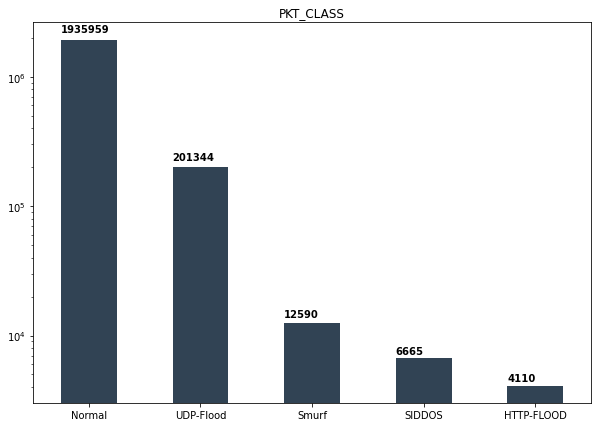

In [ ]:
import math
fig, ax = plt.subplots(figsize=(10,7)) 

df2['PKT_CLASS'].value_counts().plot.bar(logy=True, subplots=True, color='#314354', rot=0 )

for i, v in enumerate(df2['PKT_CLASS'].value_counts()):
    ax.text(i - .25, (ax.patches[i].get_height() + math.log(v)*v*0.01), str(v), 
            color='black', fontweight='bold')



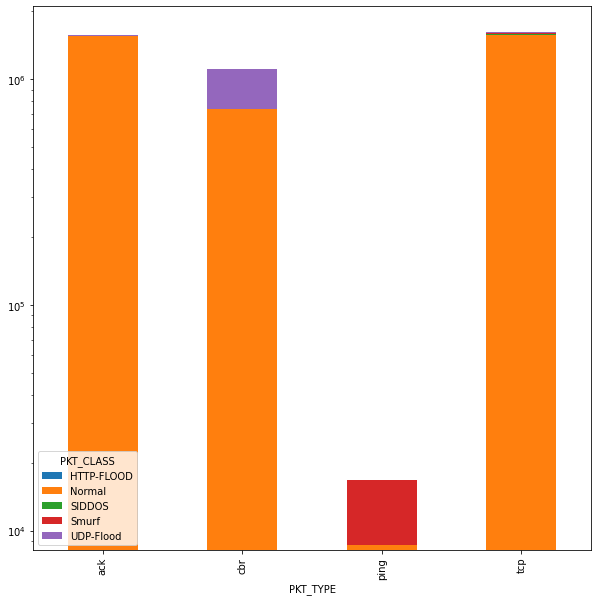

In [ ]:
class_type=pd.pivot_table(df2[['PKT_CLASS', 'PKT_TYPE']], index=["PKT_TYPE"], columns="PKT_CLASS", aggfunc=np.count_nonzero).fillna(0).astype(int)
class_type.plot.bar(stacked=True, logy=True, figsize=(10,10))

In [ ]:
data = df2.sample(frac=0.9, random_state=123)
data_unseen = df2.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1944601, 28)
Unseen Data For Predictions: (216067, 28)


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [ ]:
from pycaret.classification import *


In [ ]:
from pycaret.classification import *

clf_base = setup(data, target = 'PKT_CLASS', session_id=1,
             log_experiment=True, experiment_name='base', categorical_features = categoricals[0:-1])

,Description,Value
0,session_id,1
1,Target,PKT_CLASS
2,Target Type,Multiclass
3,Label Encoded,"HTTP-FLOOD: 0, Normal: 1, SIDDOS: 2, Smurf: 3,..."
4,Original Data,"(1944601, 28)"
5,Missing Values,False
6,Numeric Features,23
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
boosting_and_lr = compare_models(include=list(['lr']), fold = 5,)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9863,0.9370,0.8218,0.9865,0.9851,0.9229,0.9254,906.686
lr,Logistic Regression,0.9806,0.9359,0.4422,0.9749,0.9772,0.8884,0.8925,889.450


In [ ]:
#best = compare_models(fold = 5) #include all

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=123)

clf_under = setup(data, target = 'PKT_CLASS', session_id=1, fix_imbalance=True, fix_imbalance_method=undersampler,
             log_experiment=True, experiment_name='rebalance1', categorical_features = categoricals[0:-1])

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:54:47
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
SRC_ADD,Numeric
DES_ADD,Numeric
PKT_ID,Numeric
FROM_NODE,Numeric
TO_NODE,Numeric
PKT_TYPE,Categorical
PKT_SIZE,Numeric
FLAGS,Categorical
FID,Numeric
SEQ_NUMBER,Numeric


We could probably undersample the bigger classes, or maybe even try a mix of SMOTE/ROSE with undersampling of the "Normal" class

Anyway, this needs to be validated for each model

In [ ]:
ada = create_model("ada", fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3869,0.9365,0.5328,0.9004,0.4644,0.0855,0.1993
1,0.0875,0.4488,0.5064,0.0169,0.0247,0.0300,0.0942
2,0.4500,0.7148,0.4449,0.8972,0.5405,0.0990,0.1998
3,0.4491,0.9360,0.5573,0.9012,0.5333,0.1117,0.2276
4,0.4480,0.9343,0.5446,0.9014,0.5323,0.1102,0.2267
Mean,0.3643,0.7941,0.5172,0.7234,0.4191,0.0873,0.1895
SD,0.1405,0.1926,0.0399,0.3532,0.1991,0.0301,0.0492


In [ ]:
tuned_ada = tune_model(ada)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:54:14
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Ada Boost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: ignored